# Profiling tiling of titiler-pgstac and titiler-xarray

This notebook profiles code for tiling CMIP6 data via 2 methods:

1. pgSTAC + COGs: The first method uses a (local) pgSTAC database for storing metadata about COGs on S3. The libraries used are pgstac for reading STAC metadata and rio_tiler's rasterio for reading COGs on S3.
2. kerchunk + netCDF: The second method uses a (local) kerchunk reference file for NetCDF files stored on S3. The libraries used are xarray for reading the Zarr metadata and rio_tiler's XarrayReader for reading data from the NetCDFs on S3.

In the future, the following improvements and additions to this profiling code will be made:

1. Store metadata in AWS: Right now, metadata is being generated and accessed locally. A pgSTAC RDS instance will be used to store metadata and a kerchunk reference file will be stored in S3.
2. Execute on AWS: A JupyterHub in us-west-2 will be used to run the profiling code.
3. Test more tiles: The profiling code will be run on different tiles to get a sense of the performance at different zoom levels.
4. Test with a Zarr store. The profiling code will be run on a Zarr store to compare the performance of reading from a Zarr store vs. reading from a NetCDF via kerchunk.
5. Test different chunking strategies: The profiling code will be run on a few different Zarr stores with different chunking schemes.
6. Test a higher resolution dataset.

In [1]:
import io
from PIL import Image
import os

# At this time, this profiling code uses files stored in s3://climatedashboard-data, which is a protected bucket.
os.environ['AWS_PROFILE'] = 'veda-dev'
os.environ['GDAL_INGESTED_BYTES_AT_OPEN'] = '32768'
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'
os.environ['GDAL_HTTP_MERGE_CONSECUTIVE_RANGES'] = 'YES'
os.environ['GDAL_HTTP_MULTIPLEX'] = 'YES'
os.environ['GDAL_HTTP_VERSION'] = '2'
os.environ['VSI_CACHE'] = 'TRUE'

In [2]:
xyz_tile = (0,0,0)

## Profile titiler-pgstac

In [3]:
%load_ext autoreload
%autoreload
import pgstac.profile_pgstac as profile_pgstac 

### We can also run profiling via tile bench

In [4]:
#!pip install tilebench
#!tilebench profile s3://climatedashboard-data/cmip6/monthly/CMIP6_ensemble_median/tas/tas_month_ensemble-median_historical_195004.tif \
#    --tile 0-0-0 --add-cprofile --add-stdout --config GDAL_DISABLE_READDIR_ON_OPEN=EMPTY_DIR --config CPL_TIMESTAMP=ON | jq

In [5]:
query = {
  "collections": [
    "CMIP6_ensemble_median_TAS"
  ],
  "filter": {
    "op": "t_intersects",
    "args": [
      {
        "property": "datetime"
      },
      {
        "interval": [
          "1950-04-01T00:00:00Z",
          #"1950-05-01T00:00:00Z"
        ]
      }
    ]
  },
  "filter-lang": "cql2-json"
}

image_and_assets, cprofile = profile_pgstac.tile(*xyz_tile, query=dict(query))
cprofile

time in rasterio.open: 932.08
time initiating WarpedVRT: 1.16
time reading WarpedVRT: 544.41
time creating ImageData: 0.02
time in rasterio.io.reader#part: 551.52
time in MultiBaseReader#tile.tile: 556.48
{'pgstac-search': 68.92, 'get_tile': [1498.16], 'mosaic': 1500.51}


{'cprofile': ['   ncalls  tottime  percall  cumtime  percall filename:lineno(function)',
  "       11    1.547    0.141    1.547    0.141 {method 'acquire' of '_thread.lock' objects}",
  '        4    0.084    0.021    0.085    0.021 connection.py:949(wait)',
  '        2    0.001    0.000    0.001    0.000 core.py:3433(__setmask__)']}

**NOTES:**

* There are 2 parts to the overall timing of generating the image - `pgstac-search` and `get_tile`.
* `get_tile` above is a list with a timing for each tif. The bulk of this time is in `CustomSTACReader#tile`. That function has a subfunction `_reader` which wraps `src_dst.tile` in `self.reader`.
* The `CustomSTACReader`'s `reader` attribute is `BaseReader` from `rio_tiler.io.base`. There is no init function for BaseReader so I don't think any time is spent initializing the reader.
* `CustomSTACReader` inherits from `MultiBaseReader` so the `#tile` function is defined in that class.
* The `MultiBaseReader#tile` function also has a `_reader` subfunction which is called for each asset.
* The code for rio_tiler's `MultiBaseReader#tile#_reader` can be thought of as a **initialize reader** step and a **tile** step. 
* The bulk of the `get_tile` time is spent in the **initialize reader** step of `MultiBaseReader#tile#_reader`. The initialization of `MultiBaseReader#reader` spends most of it's time in `rasterio.open`. I have not dug into the subcalls of `rasterio.open`
* `MultiBaseReader#tile#tile` is roughly equivalent to `rasterio.io.reader#part` and wraps the reading of the WarpedVRT, so should be the sum of the previous calls.


/Users/aimeebarciauskas/github/developmentseed/tile-benchmarking/profiling/venv-profiling/lib/python3.9/site-packages/rio_tiler/models.py:648: InvalidDatatypeWarning: Invalid type: `float64` for the `PNG` driver. Data will be rescaled using min/max type bounds or dataset_statistics.
  warnings.warn(


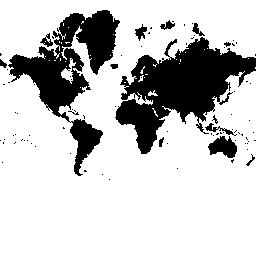

In [6]:
content = image_and_assets[0].render(
    img_format='PNG'
)

im = Image.open(io.BytesIO(content))
im

## Profile titiler-xarray

In [7]:
%load_ext autoreload
%autoreload
import xarray_tile_reader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
image_and_assets, cprofile = xarray_tile_reader.tile(
    "cmip6-reference/combined_cmip6_kerchunk.json", 
    *xyz_tile,
    reference=True,
    anon=False,
    variable="tas",
)
cprofile

/Users/aimeebarciauskas/github/developmentseed/tile-benchmarking/profiling/zarr_reader.py:40: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xarray.open_dataset(src_path, **xr_open_args)


Time elapsed for xarray.open_datset: 903.21
Time elapsed for dimension arrangement and array pre-processing: 20.23
Time elapsed for clipping data via rasterio: 16.87026
Time elapsed for reproject: 478.68609
Time elapsed for creating ImageData: 0.6001


{'cprofile': ['   ncalls  tottime  percall  cumtime  percall filename:lineno(function)',
  "      107    1.259    0.012    1.259    0.012 {method 'acquire' of '_thread.lock' objects}",
  '      160    0.012    0.000    0.012    0.000 {built-in method marshal.loads}',
  '        4    0.011    0.003    0.023    0.006 core.py:1865(_process_chunk)',
  '        1    0.009    0.009    0.010    0.010 {rasterio._warp._reproject}',
  '      157    0.009    0.000    0.009    0.000 {built-in method builtins.compile}',
  '    65792    0.009    0.000    0.009    0.000 http_websocket.py:124(<genexpr>)',
  '      768    0.008    0.000    0.008    0.000 {built-in method posix.stat}',
  '    19/17    0.008    0.000    0.011    0.001 {built-in method _imp.create_dynamic}',
  '        1    0.007    0.007    0.007    0.007 {built-in method zlib.decompress}',
  '        1    0.007    0.007    0.015    0.015 http_websocket.py:124(<listcomp>)',
  '      460    0.006    0.000    0.022    0.000 {built-in metho

/Users/aimeebarciauskas/github/developmentseed/tile-benchmarking/profiling/venv-profiling/lib/python3.9/site-packages/rio_tiler/models.py:648: InvalidDatatypeWarning: Invalid type: `float32` for the `PNG` driver. Data will be rescaled using min/max type bounds or dataset_statistics.
  warnings.warn(
/Users/aimeebarciauskas/github/developmentseed/tile-benchmarking/profiling/venv-profiling/lib/python3.9/site-packages/rio_tiler/models.py:140: RuntimeWarning: invalid value encountered in cast
  return data.astype(out_dtype)


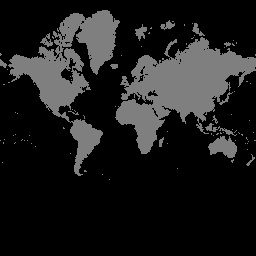

In [9]:
content = image_and_assets.render(
    img_format='PNG'
)

im = Image.open(io.BytesIO(content))
im